In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.nice(19)

19

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
from astropy import constants as c
%matplotlib inline

#styling
import seaborn as sns
sns.set_style(style='ticks', rc=None)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

matplotlib.rcParams.update({'font.size': 15})
pl.rcParams['ytick.labelsize'] = 'medium'
pl.rcParams['xtick.labelsize'] =  'medium'

In [3]:
df_all=pd.read_csv('data/PS_2025.01.07_21.46.16_all.csv', skiprows=295, delimiter=',',na_values=[''])
df_all.head()

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,3,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,1,2,...,2023-09-19,2023-08,2023-09-19,2,1,2,0,0,0,0
1,4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,...,2018-09-04,2017-03,2018-09-06,0,1,1,0,0,0,0
2,8,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,1,1,...,2023-09-19,2023-08,2023-09-19,0,1,1,0,0,0,0
3,15,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,1,1,...,2023-06-12,2022-09,2023-06-12,0,1,4,1,0,0,0
4,18,16 Cyg B b,16 Cyg B,b,HD 186427,HIP 96901,TIC 27533327,Gaia DR2 2135550755683407232,1,3,...,2018-09-04,2017-03,2018-09-06,5,1,4,3,0,0,0


### luminosity情報のある星が少ない！ => Stefan-Boltzmannから出す
本当はSEDでFbolを出すと一番いいらしい

In [4]:
from astropy import constants as ascon
ascon.sigma_sb

<<class 'astropy.constants.codata2018.CODATA2018'> name='Stefan-Boltzmann constant' value=5.6703744191844314e-08 uncertainty=0.0 unit='W / (K4 m2)' reference='CODATA 2018'>

In [5]:
sb = ascon.sigma_sb.value
Rsun = ascon.R_sun.value
Lsun = ascon.L_sun.value

df_all['st_lum_calc']=np.log10(4 * np.pi  * (df_all['st_rad']*Rsun)**2 * sb * df_all['st_teff']**4  /Lsun)

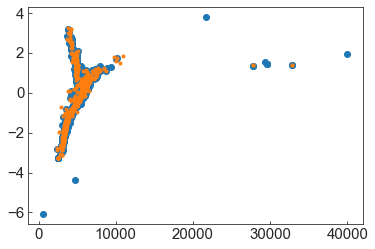

In [6]:
pl.plot(df_all['st_teff'], df_all['st_lum_calc'], 'o')
pl.plot(df_all['st_teff'], df_all['st_lum'], '.')

ok!

In [9]:
#detection method
df_transit = df_all[df_all['discoverymethod']=='Transit']
df_other = df_all[df_all['discoverymethod']!='Transit']
df_rv = df_all[df_all['discoverymethod']=='Radial Velocity']
df_mic = df_all[df_all['discoverymethod']=='Microlensing']

In [11]:
df_all[df_all['hostname'].str.contains('WD', na=False)]

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec,st_lum_calc
5738,37806,WD 0806-661 b,WD 0806-661,b,NaN,NaN,TIC 306826966,Gaia DR2 5274517467840296832,1,1,...,2011-05,2022-04-12,2,0,0,0,0,0,0,NaN
5739,37809,WD 1856+534 b,WD 1856+534,b,NaN,NaN,TIC 267574918,Gaia DR2 2146576589564898688,1,3,...,2020-09,2020-12-17,4,0,0,0,0,0,0,-4.353223


In [12]:
df_multi = df_transit[df_transit['sy_pnum']>4].sort_values(by='sy_pnum', ascending=True).reset_index(drop=True)
name_multi = df_multi['hostname'].drop_duplicates().tolist()
len(name_multi)

32

In [13]:
df = df_multi[df_multi['pl_name'].str.contains('TOI-1136 b', na=False)]
df['pl_rade']

120   NaN
Name: pl_rade, dtype: float64

In [14]:
#from Dai 2023
pl_1136 = [1.90,2.879,4.627,2.639,3.88,2.53]

for i, idx in enumerate(['b', 'c', 'd', 'e', 'f', 'g']):
    mask = df_multi['pl_name'].str.contains(f'TOI-1136 {idx}', na=False)
    df_multi.loc[mask, 'pl_rade'] = pl_1136[i]

In [15]:
name_multi2 = name_multi.copy()
name_multi2[-1]='Kepler-90'

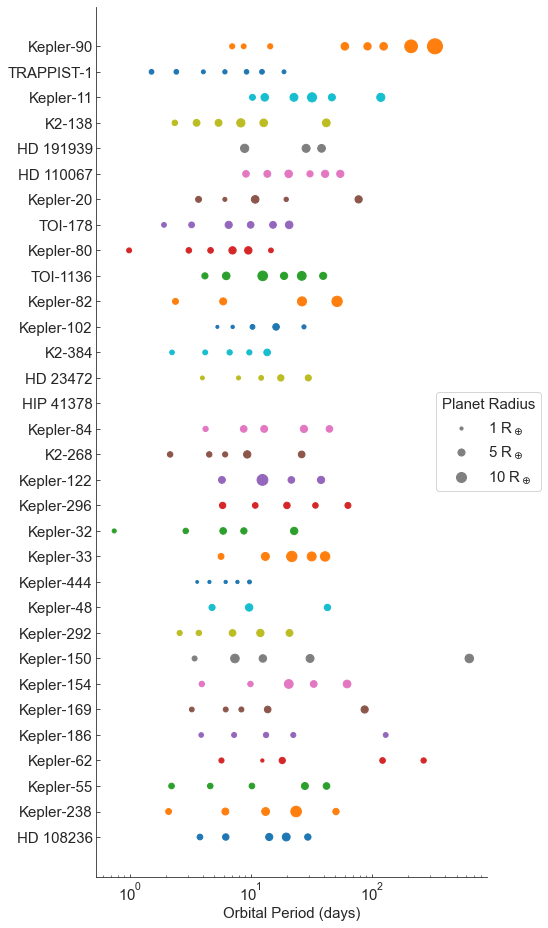

In [16]:
f = pl.figure(figsize=(7, len(name_multi) *0.5))  

for i, name in enumerate(name_multi):
    df_tmp = df_multi[df_multi['hostname'].str.contains(name, na=False)]
    sizes = df_tmp['pl_rade'] * 20
    pl.scatter(df_tmp['pl_orbper'], [i]*len(df_tmp), s=sizes)  
    
for r in [1, 5, 10]:  
    pl.scatter([], [], s=r*10, label=f'{r} R$_\oplus$', color='gray')
pl.legend(title='Planet Radius', loc='center left',
           bbox_to_anchor=(0.85, 0.5), frameon=True)


pl.yticks(ticks=range(len(name_multi)), labels=name_multi2)

pl.xscale('log')
pl.xlabel('Orbital Period (days)')
#pl.tight_layout()

ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

f.savefig('compact_multi.png', bbox_inches='tight')

In [17]:
df_tran = df_all[df_all['pl_rade'].notna()]
df_tran=df_tran[df_tran['st_teff']<25000]   #KOI-55を除く
len(df_tran)

4259

In [18]:
len(df_transit)

4329

In [19]:
len(df_all[df_all['st_lum'].notna()])

1284

In [20]:
df_tmp = df_all[df_all['st_teff'].notna()]
len(df_tmp[df_tmp['st_rad'].notna()])

4959

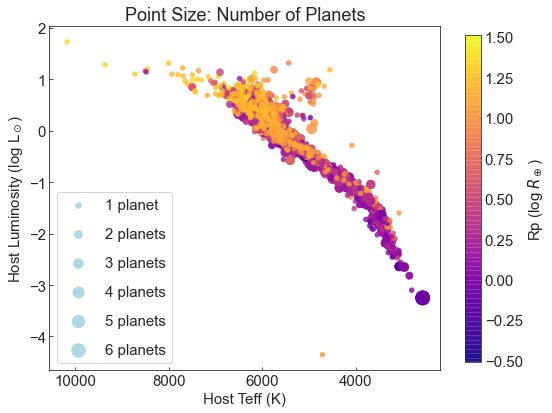

In [40]:
fig, axs = pl.subplots(1, 1, figsize=(8, 6), sharey=True)

#df = df_giant
df = df_transit.copy()
df['log_pl_rade'] = np.log10(df['pl_rade'])


#df = df_transit
#df['log_pl_rade'] = np.log10(df['pl_rade'])

def scale_size(series, factor=30):
    return series.fillna(0) * factor


sc1 = axs.scatter(df['st_teff'], df['st_lum_calc'], 
                     c=df['log_pl_rade'], 
                     s=scale_size(df['sy_pnum']), 
                     cmap='plasma', alpha=0.8, edgecolors='none')

axs.invert_xaxis()
axs.set_xlabel('Host Teff (K)')
axs.set_ylabel('Host Luminosity (log L$_\odot$)')
axs.set_title('Point Size: Number of Planets')

# 凡例のためのサイズ見本
for i in range(1, 7):
    axs.scatter([], [], c='lightblue', s=scale_size(pd.Series(i))[0], label=f'{i} planet{"s" if i > 1 else ""}')
axs.legend(scatterpoints=1, frameon=True, labelspacing=1, loc='lower left', title='')

cbar = fig.colorbar(sc1, shrink=0.95)
cbar.set_label('Rp (log $R_\oplus$)')

pl.tight_layout()
fig.savefig('HR_host.png', bbox_inches='tight')

外れ値の奴らをみてみる

In [41]:
df_transit[df_transit['st_lum_calc']<-4]

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec,st_lum_calc,log_pl_rade
5739,37809,WD 1856+534 b,WD 1856+534,b,NaN,NaN,TIC 267574918,Gaia DR2 2146576589564898688,1,3,...,2020-12-17,4,0,0,0,0,0,0,-4.353223,1.017033


In [63]:
df_transit[df_transit['st_lum_calc']>1]

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec,st_lum_calc,log_pl_rade
78,217,BD-14 3065 b,BD-14 3065 A,b,NaN,NaN,TIC 293607057,Gaia DR2 3751877374435102720,1,3,...,2024-06-25,0,0,0,0,0,0,0,1.061015,1.334253
399,1408,HAT-P-69 b,HAT-P-69,b,NaN,NaN,TIC 379929661,Gaia DR2 3080104185367102592,1,1,...,2019-08-15,0,0,0,0,0,0,0,1.001326,1.273834
401,1437,HAT-P-70 b,HAT-P-70,b,HD 287325,NaN,TIC 399870368,Gaia DR2 3291455819447952768,1,1,...,2019-08-15,0,0,0,0,1,0,0,1.201146,1.321412
469,1747,HATS-70 b,HATS-70,b,NaN,NaN,TIC 98545929,Gaia DR2 5605119586158973440,1,1,...,2019-02-14,0,0,0,0,0,0,0,1.100102,1.190696
1116,3385,HD 56414 b,HD 56414,b,HD 56414,NaN,TIC 300038935,Gaia DR2 5268547016621360768,1,1,...,2022-09-14,0,0,0,0,0,0,0,1.158445,0.569374
1370,4031,K2-11 b,K2-11,b,NaN,NaN,TIC 301609547,Gaia DR2 3810535361999701376,1,1,...,2015-07-16,0,0,0,0,0,0,0,1.318467,0.877947
1784,5474,K2-52 b,K2-52,b,NaN,NaN,TIC 399155300,Gaia DR2 6049057713786919936,1,1,...,2019-01-31,1,0,0,0,0,0,0,1.052077,1.255273
1853,5787,KELT-20 b,KELT-20,b,HD 185603,HIP 96618,TIC 69679391,Gaia DR2 2033123654092592384,1,1,...,2017-11-02,0,1,0,0,3,0,0,1.103009,1.290369
1863,5851,KELT-9 b,KELT-9,b,HD 195689,HIP 101252,TIC 16740101,Gaia DR2 2064327278651198336,1,2,...,2017-06-05,1,1,0,0,5,6,0,1.729801,1.326254
2178,8314,Kepler-1115 b,Kepler-1115,b,NaN,NaN,TIC 138960099,Gaia DR2 2076483616656410496,1,1,...,2016-05-10,1,0,0,0,0,0,0,1.144369,0.230449


In [60]:
df_transit[df_transit['st_teff']>8000]

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec,st_lum_calc,log_pl_rade
401,1437,HAT-P-70 b,HAT-P-70,b,HD 287325,NaN,TIC 399870368,Gaia DR2 3291455819447952768,1,1,...,2019-08-15,0,0,0,0,1,0,0,1.201146,1.321412
1116,3385,HD 56414 b,HD 56414,b,HD 56414,NaN,TIC 300038935,Gaia DR2 5268547016621360768,1,1,...,2022-09-14,0,0,0,0,0,0,0,1.158445,0.569374
1853,5787,KELT-20 b,KELT-20,b,HD 185603,HIP 96618,TIC 69679391,Gaia DR2 2033123654092592384,1,1,...,2017-11-02,0,1,0,0,3,0,0,1.103009,1.290369
1863,5851,KELT-9 b,KELT-9,b,HD 195689,HIP 101252,TIC 16740101,Gaia DR2 2064327278651198336,1,2,...,2017-06-05,1,1,0,0,5,6,0,1.729801,1.326254
2178,8314,Kepler-1115 b,Kepler-1115,b,NaN,NaN,TIC 138960099,Gaia DR2 2076483616656410496,1,1,...,2016-05-10,1,0,0,0,0,0,0,1.144369,0.230449
5632,36994,WASP-178 b,WASP-178,b,HD 134004,NaN,TIC 160708862,Gaia DR2 6003809889735481856,1,1,...,2019-10-10,1,0,0,0,0,2,0,1.285230,1.307239


In [61]:
#pre-MS入ってる？
df_young = df_transit[df_transit['st_age']<=0.1]

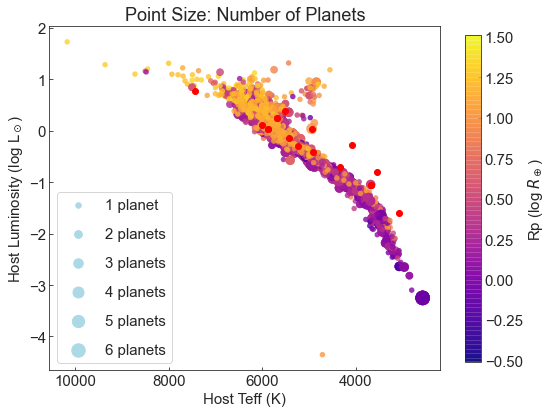

In [62]:
fig, axs = pl.subplots(1, 1, figsize=(8, 6), sharey=True)

def scale_size(series, factor=30):
    return series.fillna(0) * factor

df = df_young.copy()
df['log_pl_rade'] = np.log10(df['pl_rade'])


sc1 = axs.scatter(df['st_teff'], df['st_lum_calc'], 
                     c='red', zorder=30)

df = df_transit.copy()
df['log_pl_rade'] = np.log10(df['pl_rade'])


sc1 = axs.scatter(df['st_teff'], df['st_lum_calc'], 
                     c=df['log_pl_rade'], 
                     s=scale_size(df['sy_pnum']), 
                     cmap='plasma', alpha=0.8, edgecolors='none')



axs.invert_xaxis()
axs.set_xlabel('Host Teff (K)')
axs.set_ylabel('Host Luminosity (log L$_\odot$)')
axs.set_title('Point Size: Number of Planets')

# 凡例のためのサイズ見本
for i in range(1, 7):
    axs.scatter([], [], c='lightblue', s=scale_size(pd.Series(i))[0], label=f'{i} planet{"s" if i > 1 else ""}')
axs.legend(scatterpoints=1, frameon=True, labelspacing=1, loc='lower left', title='')

cbar = fig.colorbar(sc1, shrink=0.95)
cbar.set_label('Rp (log $R_\oplus$)')

pl.tight_layout()
fig.savefig('HR_host.png', bbox_inches='tight')

In [58]:
# gianｔ周りの惑星は？
df_giant=df_tran[df_tran['st_logg']<3]
len(df_giant)

1

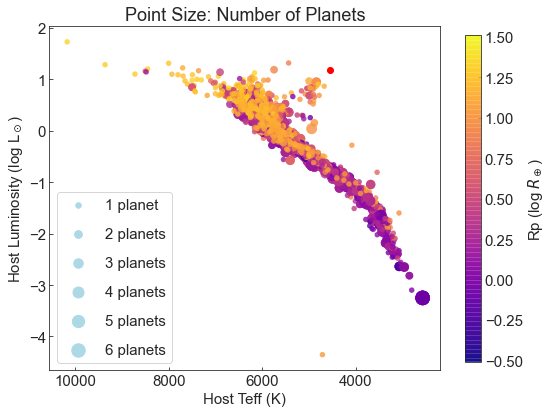

In [59]:
fig, axs = pl.subplots(1, 1, figsize=(8, 6), sharey=True)

def scale_size(series, factor=30):
    return series.fillna(0) * factor

df = df_giant.copy()
df['log_pl_rade'] = np.log10(df['pl_rade'])


sc1 = axs.scatter(df['st_teff'], df['st_lum_calc'], 
                     c='red', zorder=30)

df = df_transit.copy()
df['log_pl_rade'] = np.log10(df['pl_rade'])


sc1 = axs.scatter(df['st_teff'], df['st_lum_calc'], 
                     c=df['log_pl_rade'], 
                     s=scale_size(df['sy_pnum']), 
                     cmap='plasma', alpha=0.8, edgecolors='none')



axs.invert_xaxis()
axs.set_xlabel('Host Teff (K)')
axs.set_ylabel('Host Luminosity (log L$_\odot$)')
axs.set_title('Point Size: Number of Planets')

# 凡例のためのサイズ見本
for i in range(1, 7):
    axs.scatter([], [], c='lightblue', s=scale_size(pd.Series(i))[0], label=f'{i} planet{"s" if i > 1 else ""}')
axs.legend(scatterpoints=1, frameon=True, labelspacing=1, loc='lower left', title='')

cbar = fig.colorbar(sc1, shrink=0.95)
cbar.set_label('Rp (log $R_\oplus$)')

pl.tight_layout()
fig.savefig('HR_host.png', bbox_inches='tight')

/tmp/ipykernel_1844967/2316170452.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_pl_rade'] = np.log10(df['pl_rade'])
/tmp/ipykernel_1844967/2316170452.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_pl_rade'] = np.log10(df['pl_rade'])


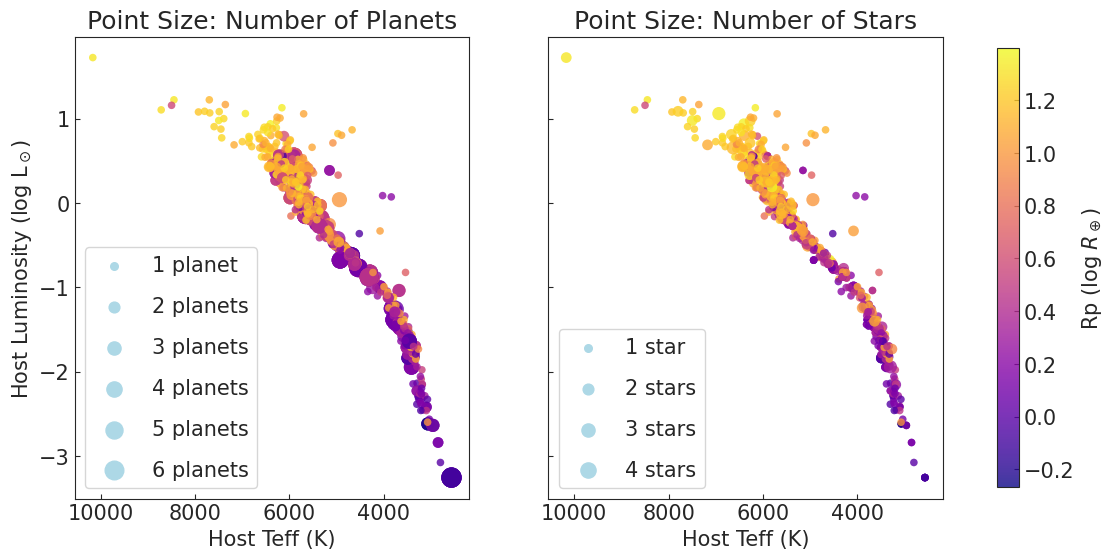

In [168]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

df = df_other
df['log_pl_rade'] = np.log10(df['pl_rade'])


df = df_transit
df['log_pl_rade'] = np.log10(df['pl_rade'])

def scale_size(series, factor=30):
    return series.fillna(0) * factor



sc1 = axs[0].scatter(df['st_teff'], df['st_lum'], 
                     c=df['log_pl_rade'], 
                     s=scale_size(df['sy_pnum']), 
                     cmap='plasma', alpha=0.8, edgecolors='none')

axs[0].invert_xaxis()
axs[0].set_xlabel('Host Teff (K)')
axs[0].set_ylabel('Host Luminosity (log L$_\odot$)')
axs[0].set_title('Point Size: Number of Planets')

# 凡例のためのサイズ見本
for i in range(1, 7):
    axs[0].scatter([], [], c='lightblue', s=scale_size(pd.Series(i))[0], label=f'{i} planet{"s" if i > 1 else ""}')
axs[0].legend(scatterpoints=1, frameon=True, labelspacing=1, loc='lower left', title='')

# 右：恒星数をサイズに
sc2 = axs[1].scatter(df['st_teff'], df['st_lum'], 
                     c=df['log_pl_rade'], 
                     s=scale_size(df['sy_snum']), 
                     cmap='plasma', alpha=0.8, edgecolors='none')

axs[1].invert_xaxis()
axs[1].set_xlabel('Host Teff (K)')
axs[1].set_title('Point Size: Number of Stars')

# 凡例（恒星数）
for i in range(1, 5):
    axs[1].scatter([], [], c='lightblue', s=scale_size(pd.Series(i))[0], label=f'{i} star{"s" if i > 1 else ""}')
axs[1].legend(scatterpoints=1, frameon=True, labelspacing=1, loc='lower left', title='')

# カラーバー共通
cbar = fig.colorbar(sc1, ax=axs.ravel().tolist(), shrink=0.95)
cbar.set_label('Rp (log $R_\oplus$)')

#plt.tight_layout()


In [169]:
df = df_transits
pl.scatter(df['st_teff'], df['st_lum'], 'x', ms=4, alpha=0.7, color='gray', zorder=0)

#pl.plot(df_transit['pl_orbper'], df_transit['pl_bmasse'], '.', ms=5, alpha=0.7, color='tomato', zorder=1)

NameError: name 'df_transits' is not defined

In [ ]:
f, ax = pl.subplots(1, 1, figsize=(8, 5))
ax.loglog()

pl.plot(df_other['pl_orbper'], df_other['pl_bmasse'], 'x', ms=4, alpha=0.7, color='gray', zorder=0)
pl.plot(df_transit['pl_orbper'], df_transit['pl_bmasse'], '.', ms=5, alpha=0.7, color='tomato', zorder=1)
#pl.plot(df_rv['pl_orbper'], df_rv['pl_bmasse'], '.', ms=5, alpha=0.7, color='steelblue', zorder=1)

pl.ylim(1.0e-1, 5.0e4)


pl.text(6.0e4, 0.5, 'Other methods', color='gray')
pl.text(6.0e4, 1.2, 'Transits', color='tomato')

pl.xlabel(r'Orbital period (days)')
pl.ylabel(r'Planet mass $M_{\rm p}$ or $M_{\rm p}\sin i$ ($M_\oplus$)')

f.savefig('per_mass.png')

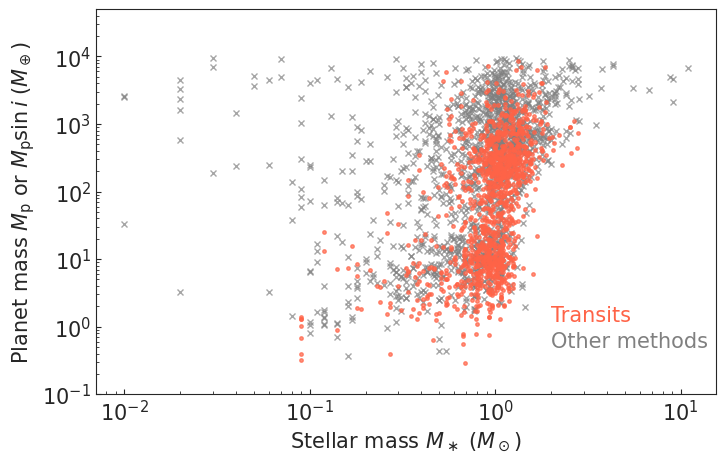

In [170]:
f, ax = pl.subplots(1, 1, figsize=(8, 5))
ax.loglog()

pl.plot(df_other['st_mass'], df_other['pl_bmasse'], 'x', ms=4, alpha=0.7, color='gray', zorder=0)
pl.plot(df_transit['st_mass'], df_transit['pl_bmasse'], '.', ms=5, alpha=0.7, color='tomato', zorder=1)
#pl.plot(df_rv['st_mass'], df_rv['pl_bmasse'], '.', ms=5, alpha=0.7, color='steelblue', zorder=1)
#pl.plot(df_mic['st_mass'], df_mic['pl_bmasse'], '.', ms=5, alpha=0.7, color='steelblue', zorder=1)

pl.ylim(1.0e-1, 5.0e4)


pl.text(2, 0.5, 'Other methods', color='gray')
pl.text(2, 1.2, 'Transits', color='tomato')

pl.xlabel(r'Stellar mass $M_\ast$ ($M_\odot$)')
pl.ylabel(r'Planet mass $M_{\rm p}$ or $M_{\rm p}\sin i$ ($M_\oplus$)')

f.savefig('mass_mass.png')

In [171]:
df_young = df_transit[df_transit['st_age']<=1]

abs_err1 = np.abs(df_young['st_ageerr1'])
abs_err2 = np.abs(df_young['st_ageerr2'])

st_ageerr = np.maximum(abs_err1, abs_err2)

df_young = df_young[st_ageerr< df_young['st_age']/3 ]
df_young

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec,log_pl_rade
52,173,AU Mic b,AU Mic,b,HD 197481,HIP 102409,TIC 441420236,Gaia DR2 6794047652729201024,1,1,...,2023-12,2024-09-28,1,1,0,1,0,0,0,0.597366
53,176,AU Mic c,AU Mic,c,HD 197481,HIP 102409,TIC 441420236,Gaia DR2 6794047652729201024,1,1,...,2023-12,2024-09-28,2,1,0,1,0,0,0,0.401745
138,384,DS Tuc A b,DS Tuc A,b,HD 222259 A,HIP 116748 A,TIC 410214986,Gaia DR2 6387058411482257536,1,2,...,2019-07,2019-07-11,2,1,0,0,0,0,0,0.755875
535,1925,HD 109833 b,HD 109833,b,HD 109833,HIP 61723,TIC 360630575,Gaia DR2 5838450865699668736,1,1,...,2022-12,2022-12-17,0,0,0,0,0,0,0,0.460597
536,1926,HD 109833 c,HD 109833,c,HD 109833,HIP 61723,TIC 360630575,Gaia DR2 5838450865699668736,1,1,...,2022-12,2022-12-17,0,0,0,0,0,0,0,0.413300
545,1939,HD 110082 b,HD 110082,b,HD 110082,HIP 62662,TIC 383390264,Gaia DR2 5765748511163751936,1,2,...,2021-04,2021-03-04,1,1,0,0,0,0,0,0.505150
809,2577,HD 18599 b,HD 18599,b,HD 18599,HIP 13754,TIC 207141131,Gaia DR2 4728513943538448512,1,2,...,2022-10,2022-11-07,1,0,0,0,0,0,0,0.414973
1130,3422,HD 63433 d,HD 63433,d,HD 63433,HIP 38228,TIC 130181866,Gaia DR2 875071278432954240,1,1,...,2024-02,2024-01-05,1,1,0,0,0,0,0,0.030600
1316,3867,HIP 67522 b,HIP 67522,b,HD 120411,HIP 67522,TIC 166527623,Gaia DR2 6113920619134019456,1,1,...,2024-09,2024-09-28,0,1,0,0,0,3,0,0.999435
1317,3871,HIP 67522 c,HIP 67522,c,HD 120411,HIP 67522,TIC 166527623,Gaia DR2 6113920619134019456,1,1,...,2024-09,2024-09-28,0,1,0,0,0,0,0,0.899602


In [172]:
P = np.linspace(1.0e-1, 10**(1.15), 100)
a1 =  10 ** (-0.33 * np.log10(P) + 1.17)
a2 =  10 ** (0.68 * np.log10(P))

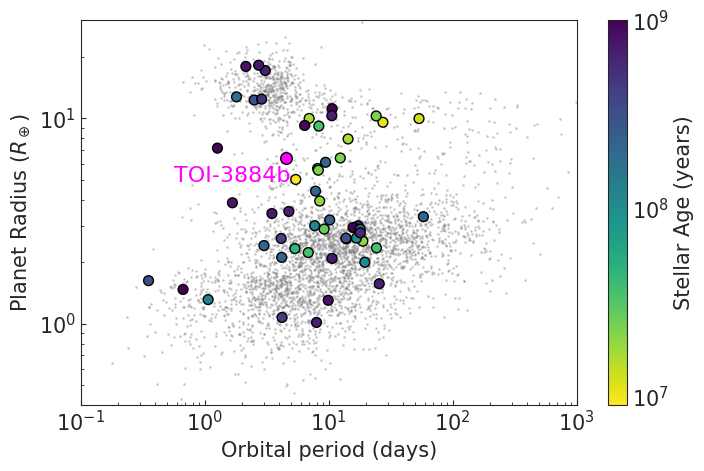

In [175]:
f, ax = pl.subplots(1, 1, figsize=(8, 5))
ax.loglog()

pl.plot(df_all['pl_orbper'], df_all['pl_rade'], '.', ms=2, alpha=0.3, color='gray', zorder=0)

sc = ax.scatter(df_young['pl_orbper'], df_young['pl_rade'], c=np.log10(df_young['st_age']*1e9), 
                cmap='viridis_r', s=50, alpha=1, edgecolor='k', zorder=1)

cbar = pl.colorbar(sc)
cbar.set_label(r'Stellar Age (years)')

# カラーバーの目盛りを設定（10^5, 10^6, 10^7, 10^8, 10^9）
cbar.set_ticks([7,8,9])
cbar.set_ticklabels([r'$10^7$', r'$10^8$', r'$10^9$'])

ax.set_xlim(1.0e-1, 1.0e3)
ax.set_ylim(4.0e-1, 3.0e1)

#pl.plot(P, a1, '-', color='tomato', zorder=-1)
#pl.plot(P, a2, '-', color='tomato', zorder=-1)
#pl.fill_between(P, a1, a2, alpha=0.15,color='tomato', zorder=-1)

#TOI-3884
ax.scatter(4.5445828, 6.43, s=70, alpha=1, edgecolor='k', color='magenta')
ax.text(4.9, 4.9, 'TOI-3884b', color='magenta', fontsize=16, ha='right')

ax.set_xlabel(r'Orbital period (days)')
ax.set_ylabel(r'Planet Radius ($R_\oplus$)')

f.savefig('per-rad-young.png')

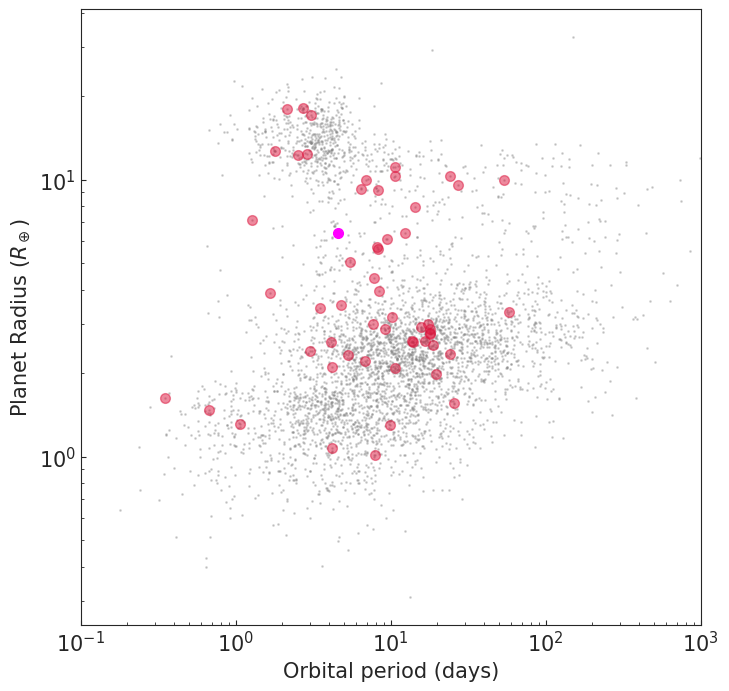

In [174]:
f,ax = pl.subplots(1,1,figsize=(8,8))
ax.loglog()

pl.plot(df_all['pl_orbper'], df_all['pl_rade'],'.', ms=2,alpha=0.3, color='gray')
pl.plot(df_young['pl_orbper'], df_young['pl_rade'],'o', ms=7, alpha=0.5, color='crimson')

pl.xlim(1.0e-1, 1.0e3)
#pl.ylim(0.4, 50)

pl.xlabel(r'Orbital period (days)')
pl.ylabel(r'Planet Radius ($R_\oplus$)')

#TOI-3884
pl.plot(4.5445828, 6.43, 'o', color='magenta', ms =7)

#f.savefig('../TLSE/K2-25/output/scatter_plot.pdf', bbox_inches='tight')

In [6]:
df_M=df_all[df_all['st_teff']<4000]
len(df_M)

393

In [7]:
df_targets = []
name_targets = []

df_tmp = df_all[df_all['hostname']=='TOI-1696']
df_targets.append(df_tmp)
name_targets.append(list(df_tmp['pl_name'])[0])

In [8]:
df_tmp = df_all[df_all['hostname']=='K2-25']
df_targets.append(df_tmp)
name_targets.append(list(df_tmp['pl_name'])[0])

df_tmp = df_all[df_all['pl_name']=='LHS 1140 b']
df_targets.append(df_tmp)
name_targets.append(list(df_tmp['pl_name'])[0])

df_tmp = df_all[df_all['pl_name']=='TRAPPIST-1 h']
df_targets.append(df_tmp)
name_targets.append(list(df_tmp['pl_name'])[0])

In [9]:
name_targets

['TOI-1696 b', 'K2-25 b', 'LHS 1140 b', 'TRAPPIST-1 h']

Text(0, 0.5, 'Planetary Radius ($R_\\oplus$)')

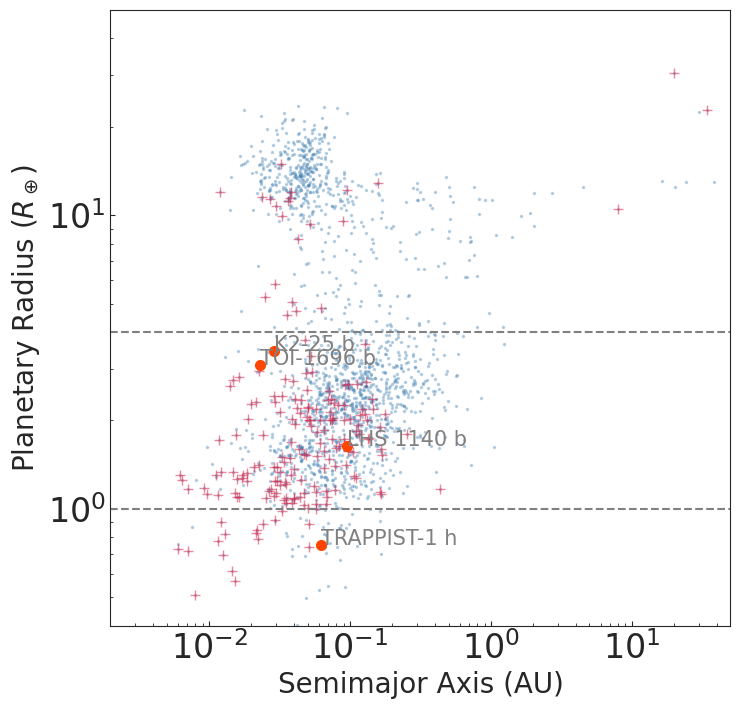

In [10]:
f,ax = pl.subplots(1,1,figsize=(8,8))
ax.loglog()

pl.plot(df_all['pl_orbsmax'], df_all['pl_rade'],'.', ms=3,alpha=0.3, color='steelblue')
pl.plot(df_M['pl_orbsmax'], df_M['pl_rade'],'+', ms=7, alpha=0.5, color='crimson')

for n in range(len(name_targets)):
    df = df_targets[n]
    #c = matplotlib.patches.Circle((df['pl_orbsmax'],df['pl_rade']), radius=0.2)
    #ax.add_patch(c)
    
    pl.plot(df['pl_orbsmax'], df['pl_rade'],'o', ms=7, alpha=1, color='orangered')
    ax.text(df['pl_orbsmax'], df['pl_rade'],name_targets[n], color='gray', fontsize=15)
    
ax.hlines(4.0, 2.0e-3, 50, linestyles='dashed', color='gray')
ax.hlines(1.0, 2.0e-3, 50, linestyles='dashed', color='gray')


pl.xlim(2.0e-3, 50)
pl.ylim(0.4, 50)

pl.xlabel(r'Semimajor Axis (AU)')
pl.ylabel(r'Planetary Radius ($R_\oplus$)')

#f.savefig('../TLSE/K2-25/output/scatter_plot.pdf', bbox_inches='tight')

In [11]:
10**1.224

16.749428760264372

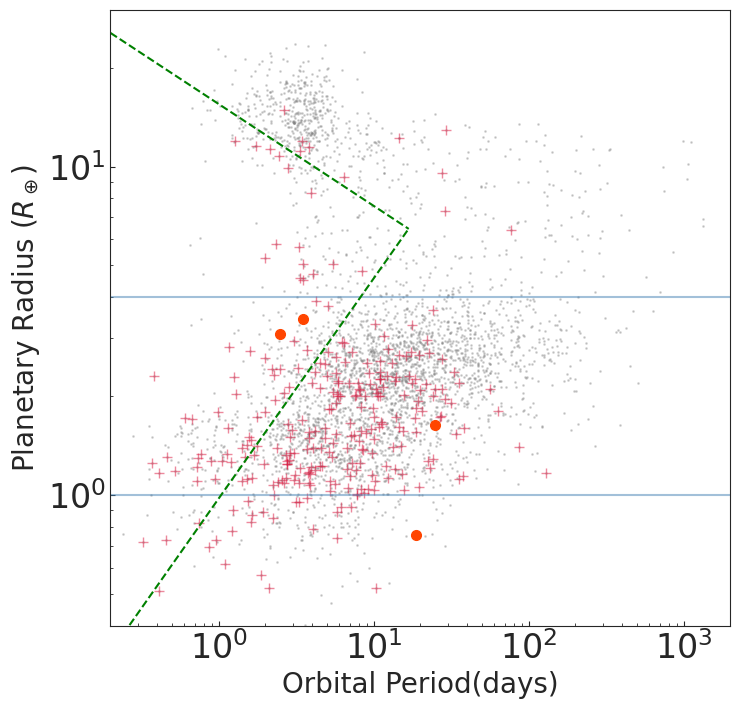

In [12]:
f,ax = pl.subplots(1,1,figsize=(8,8))
ax.loglog()

pl.plot(df_all['pl_orbper'], df_all['pl_rade'],'.', ms=2,alpha=0.3, color='gray', zorder=0)
pl.plot(df_M['pl_orbper'], df_M['pl_rade'],'+', ms=7, alpha=0.5, color='crimson')

for n in range(len(name_targets)):
    df = df_targets[n]
    #c = matplotlib.patches.Circle((df['pl_orbsmax'],df['pl_rade']), radius=0.2)
    #ax.add_patch(c)
    
    pl.plot(df['pl_orbper'], df['pl_rade'],'o', ms=7, alpha=1, color='orangered')
    #ax.text(df['pl_orbper'], df['pl_rade'],name_targets[n], color='gray', fontsize=15)
    
ax.hlines(1, 0.2, 2000, color='steelblue', alpha=0.5)
ax.hlines(4, 0.2, 2000, color='steelblue', alpha=0.5)

P = np.linspace(0.2, 16.8, 1000)
R1 = 10**(-0.31*np.log10(P) +1.19)
R2 = 10**(0.67*np.log10(P)-0.01)

pl.plot(P, R1, '--', color='green')
pl.plot(P, R2, '--', color='green')

#R=(0.254)P−(0.003±0.025),

pl.xlim(0.2, 2000)
pl.ylim(0.4, 30)

pl.xlabel(r'Orbital Period(days)')
pl.ylabel(r'Planetary Radius ($R_\oplus$)')

f.savefig('../TLSE/K2-25/output/scatter_plot.pdf', bbox_inches='tight')

In [13]:
df_all.columns

Index(['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum',
       'discoverymethod', 'disc_year', 'disc_facility', 'soltype',
       'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
       'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2',
       'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1',
       'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2

In [14]:
df_all_s = df_all[df_all['pl_bmasseerr1'].notna()]
df_all_s = df_all_s[df_all_s['pl_bmasseerr2'].notna()]
df_all_s = df_all_s[df_all_s['pl_bmasseerr1'] < 0.25 * df_all_s['pl_bmasse']]
df_all_s = df_all_s[np.abs(df_all_s['pl_bmasseerr2']) < 0.25 * df_all_s['pl_bmasse']]


df_all_s = df_all_s[df_all_s['pl_radeerr1'].notna()]
df_all_s = df_all_s[df_all_s['pl_radeerr2'].notna()]
df_all_s = df_all_s[df_all_s['pl_radeerr1'] < 0.08 * df_all_s['pl_rade']]
df_all_s = df_all_s[np.abs(df_all_s['pl_radeerr2']) < 0.08 * df_all_s['pl_rade']]

df_all_s.reset_index(drop=True)

len(df_all_s)

560

In [15]:
df_M_s=df_all_s[df_all_s['st_teff']<4000]
len(df_M_s)

57

In [16]:
df_targets_s = []
name_targets_s = []

#df_tmp = df_all[df_all['hostname']=='TOI-1696']
#df_targets.append(df_tmp)
#name_targets.append(list(df_tmp['pl_name'])[0])

In [17]:
df_tmp = df_all_s[df_all_s['hostname']=='K2-25']
df_targets_s.append(df_tmp)
name_targets_s.append(list(df_tmp['pl_name'])[0])

df_tmp = df_all_s[df_all_s['pl_name']=='LHS 1140 b']
df_targets_s.append(df_tmp)
name_targets_s.append(list(df_tmp['pl_name'])[0])

df_tmp = df_all_s[df_all_s['pl_name']=='TRAPPIST-1 h']
df_targets_s.append(df_tmp)
name_targets_s.append(list(df_tmp['pl_name'])[0])

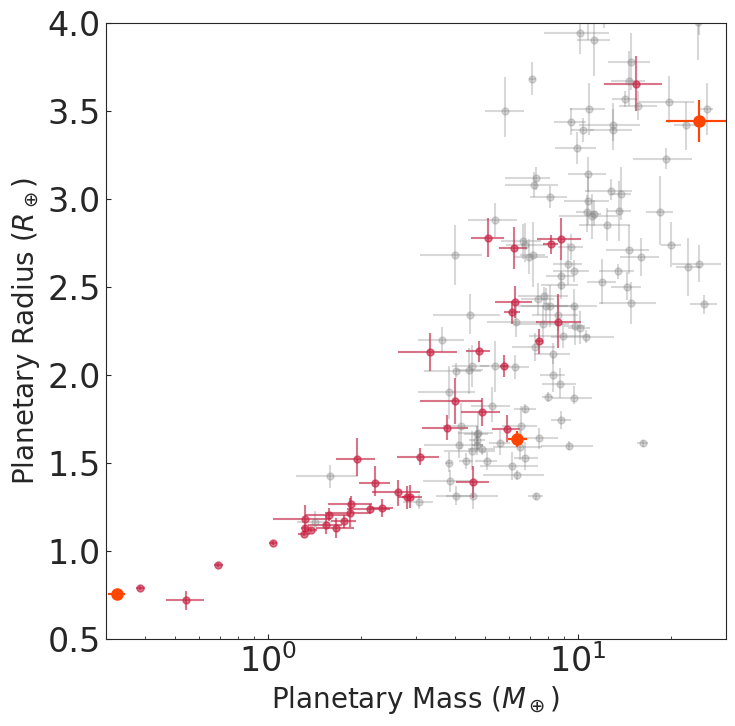

In [18]:
f,ax = pl.subplots(1,1,figsize=(8,8))
pl.xlim(0.3, 30)


pl.errorbar(df_all_s['pl_bmasse'], df_all_s['pl_rade'],xerr=[np.abs(df_all_s['pl_bmasseerr2']),df_all_s['pl_bmasseerr1']],\
            yerr=[np.abs(df_all_s['pl_radeerr2']),df_all_s['pl_radeerr1']], fmt='o', ms=5,alpha=0.3, color='gray')
pl.errorbar(df_M_s['pl_bmasse'], df_M_s['pl_rade'],xerr=[np.abs(df_M_s['pl_bmasseerr2']),df_M_s['pl_bmasseerr1']],\
            yerr=[np.abs(df_M_s['pl_radeerr2']),df_M_s['pl_radeerr1']], fmt='o', ms=5,alpha=0.5, color='crimson')
#pl.plot(df_M['pl_bmasse'], df_M['pl_rade'],'+', ms=7, alpha=0.5, color='crimson')

for n in range(len(name_targets_s)):
    df = df_targets_s[n]

    pl.errorbar(df['pl_bmasse'], df['pl_rade'],xerr=[np.abs(df['pl_bmasseerr2']),df['pl_bmasseerr1']],\
                yerr=[np.abs(df['pl_radeerr2']),df['pl_radeerr1']],fmt='o', ms=8, alpha=1, color='orangered')
    #pl.plot(df['pl_bmasse'], df['pl_rade'],'o', ms=7, alpha=1, color='orangered')
    #ax.text(df['pl_bmasse'], df['pl_rade'],name_targets[n], color='gray', fontsize=15)

pl.ylim(0.5, 4)

pl.xlabel(r'Planetary Mass ($M_\oplus$)')
pl.ylabel(r'Planetary Radius ($R_\oplus$)')
pl.xscale('log')

理論モデル
https://lweb.cfa.harvard.edu/~lzeng/planetmodels.html#mrtables　　

元論文
https://www.pnas.org/doi/10.1073/pnas.1812905116#supplementary-materials

In [19]:
files=['data/Earthlike01h500K1mbar.txt',
 'data/Earthlike03h500K1mbar.txt',
          'data/Earthlike1h500K1mbar.txt',
 'data/Earthlike2h500K1mbar.txt']
 #'data/Earthlike5h500K1mbar.txt']

df_h2 = []
for file in files:
    df_h2.append(pd.read_csv(file, sep='\t', header=None))
labels_h2=[0.1, 0.3, 1, 2]
lss = ['solid', 'dashdot', 'dashed', 'dotted']

In [20]:
glob('data/massradius*.txt')

['data/massradiusEarthlikeRocky.txt',
 'data/massradiusFe.txt',
 'data/massradius_100percentH2O_500K_1mbar.txt',
 'data/massradius_50percentH2O_500K_1mbar.txt']

In [21]:
files =['data/massradius_100percentH2O_500K_1mbar.txt',\
       'data/massradiusEarthlikeRocky.txt',\
       'data/massradiusFe.txt']

df_th = []
for file in files:
    df_th.append(pd.read_csv(file, sep='\t', header=None))
labels_th=['100% H2O', 'Earth-like (32.5% Fe+67.5% MgSiO3)', '100% Fe']

col_ths = ['steelblue', 'darkorange', 'sienna']

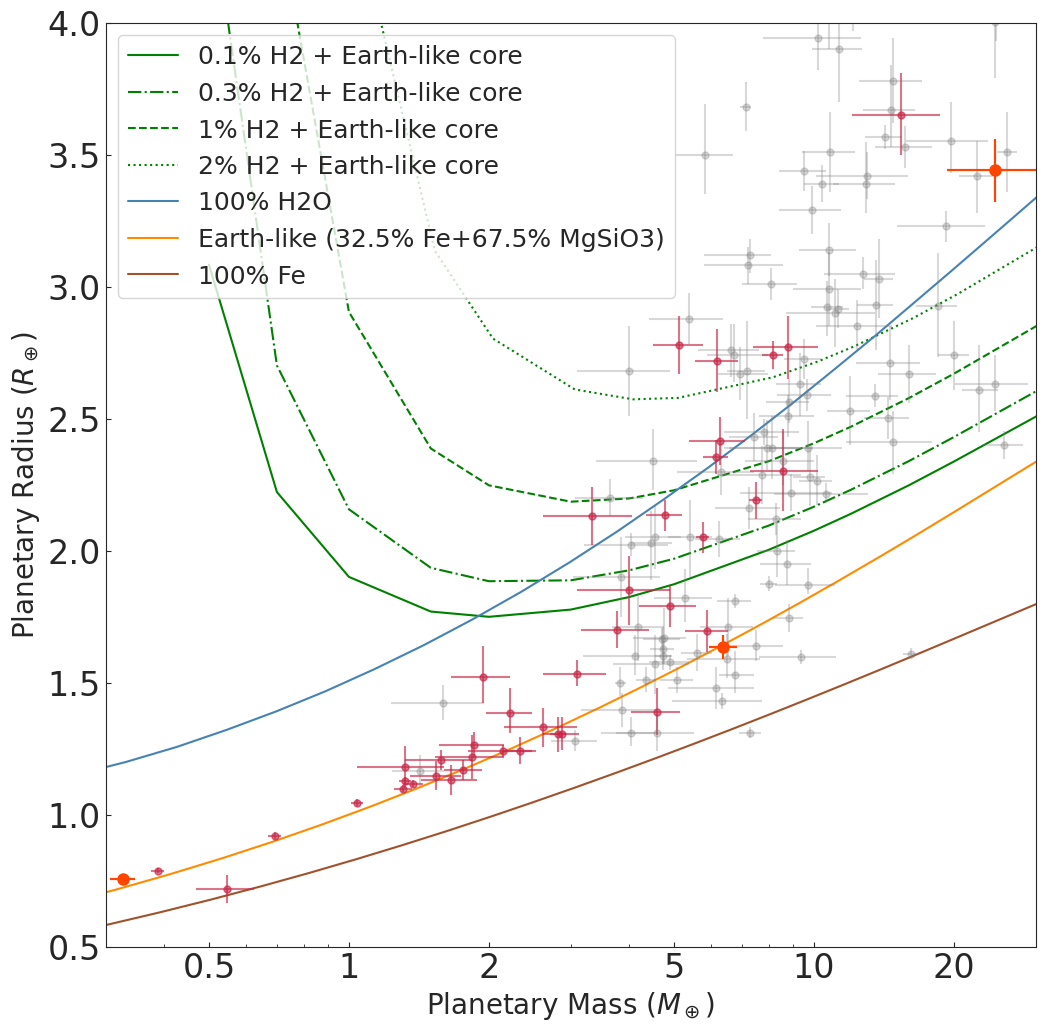

In [22]:
f,ax = pl.subplots(1,1,figsize=(12,12))
pl.xlim(0.3, 30)

for ls, lb, df in zip(lss, labels_h2, df_h2):
    pl.plot(df[0],df[1], label=r'{}% H2 + Earth-like core'.format(lb), color='green', ls=ls)
    
for col, lb, df in zip(col_ths, labels_th, df_th):
    pl.plot(df[0],df[1], label=r'{}'.format(lb), color=col, ls='solid')
    
pl.legend(fontsize=18)


pl.errorbar(df_all_s['pl_bmasse'], df_all_s['pl_rade'],xerr=[np.abs(df_all_s['pl_bmasseerr2']),df_all_s['pl_bmasseerr1']],\
            yerr=[np.abs(df_all_s['pl_radeerr2']),df_all_s['pl_radeerr1']], fmt='o', ms=5,alpha=0.3, color='gray')
pl.errorbar(df_M_s['pl_bmasse'], df_M_s['pl_rade'],xerr=[np.abs(df_M_s['pl_bmasseerr2']),df_M_s['pl_bmasseerr1']],\
            yerr=[np.abs(df_M_s['pl_radeerr2']),df_M_s['pl_radeerr1']], fmt='o', ms=5,alpha=0.5, color='crimson')
#pl.plot(df_M['pl_bmasse'], df_M['pl_rade'],'+', ms=7, alpha=0.5, color='crimson')

for n in range(len(name_targets_s)):
    df = df_targets_s[n]

    pl.errorbar(df['pl_bmasse'], df['pl_rade'],xerr=[np.abs(df['pl_bmasseerr2']),df['pl_bmasseerr1']],\
                yerr=[np.abs(df['pl_radeerr2']),df['pl_radeerr1']],fmt='o', ms=8, alpha=1, color='orangered')
    #pl.plot(df['pl_bmasse'], df['pl_rade'],'o', ms=7, alpha=1, color='orangered')
    #ax.text(df['pl_bmasse'], df['pl_rade'],name_targets[n], color='gray', fontsize=15)

pl.ylim(0.5, 4)

pl.xlabel(r'Planetary Mass ($M_\oplus$)')
pl.ylabel(r'Planetary Radius ($R_\oplus$)')
pl.xscale('log')
pl.xticks([0.5, 1, 2, 5,10, 20], ["0.5","1", "2", "5", "10", "20"])

f.savefig('mass-radius.pdf', bbox_inches='tight')

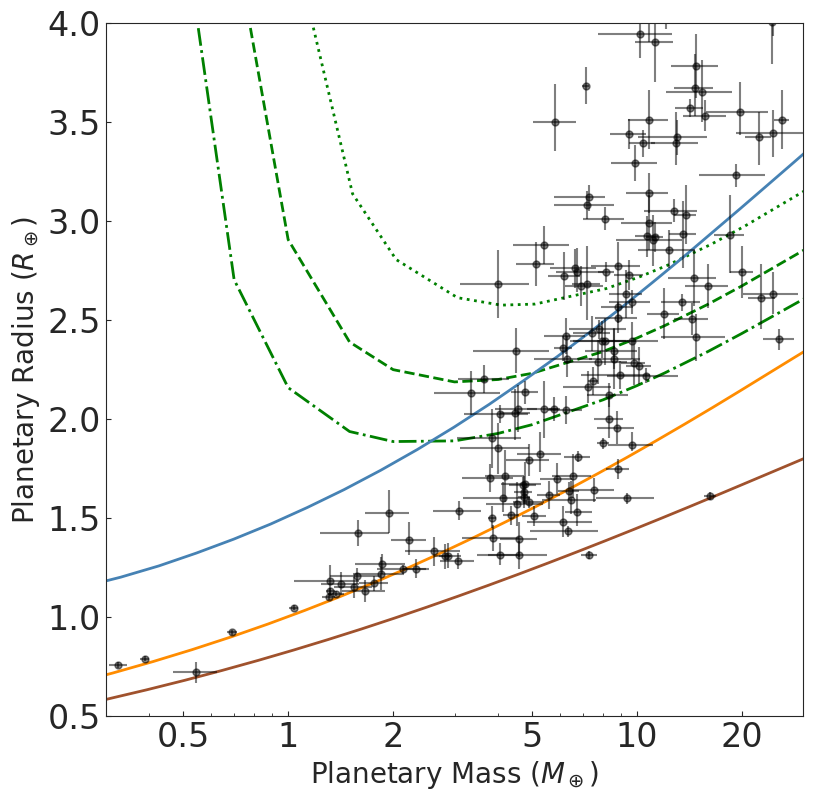

In [36]:
f,ax = pl.subplots(1,1,figsize=(9,9))
pl.xlim(0.3, 30)

for ls, lb, df in zip(lss[1:], labels_h2[1:], df_h2[1:]):
    pl.plot(df[0],df[1], label=r'{}% H2 + Earth-like core'.format(lb), color='green', ls=ls, lw=2)
    
for col, lb, df in zip(col_ths, labels_th, df_th):
    pl.plot(df[0],df[1], label=r'{}'.format(lb), color=col, ls='solid', lw=2)
    
#pl.legend(fontsize=18)


pl.errorbar(df_all_s['pl_bmasse'], df_all_s['pl_rade'],xerr=[np.abs(df_all_s['pl_bmasseerr2']),df_all_s['pl_bmasseerr1']],\
            yerr=[np.abs(df_all_s['pl_radeerr2']),df_all_s['pl_radeerr1']], fmt='o', ms=5,alpha=0.5, color='k')
#pl.errorbar(df_M_s['pl_bmasse'], df_M_s['pl_rade'],xerr=[np.abs(df_M_s['pl_bmasseerr2']),df_M_s['pl_bmasseerr1']],\
 #           yerr=[np.abs(df_M_s['pl_radeerr2']),df_M_s['pl_radeerr1']], fmt='o', ms=5,alpha=0.3, color='k')
#pl.plot(df_M['pl_bmasse'], df_M['pl_rade'],'+', ms=7, alpha=0.5, color='crimson')


pl.ylim(0.5, 4)

pl.xlabel(r'Planetary Mass ($M_\oplus$)')
pl.ylabel(r'Planetary Radius ($R_\oplus$)')
pl.xscale('log')
pl.xticks([0.5, 1, 2, 5,10, 20], ["0.5","1", "2", "5", "10", "20"])

f.savefig('mass-radius_simple.pdf', bbox_inches='tight')